In [22]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

import plotly
plotly.tools.set_credentials_file(username='quoniammm', api_key='IF7kV6idFRdoo7LdgGRp')
import plotly.plotly as py
import plotly.graph_objs as go
from wordcloud import WordCloud, STOPWORDS
# from sklearn.feature_extraction.text import CountVectorizer
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
from sklearn.model_selection import train_test_split

import nltk

import torch
import torch.nn as nn
import torch.optim as optim
import torch.nn.functional as F
from torch.autograd import Variable

%matplotlib inline

In [23]:
train = pd.read_csv('train.csv')
test = pd.read_csv('test.csv')
sample = pd.read_csv('sample_submission.csv')

In [24]:
train.head()

,id,text,author
0,id26305,"This process, however, afforded me no means of...",EAP
1,id17569,It never once occurred to me that the fumbling...,HPL
2,id11008,"In his left hand was a gold snuff box, from wh...",EAP
3,id27763,How lovely is spring As we looked from Windsor...,MWS
4,id12958,"Finding nothing else, not even gold, the Super...",HPL


In [25]:
test.head()

,id,text
0,id02310,"Still, as I urged our leaving Ireland with suc..."
1,id24541,"If a fire wanted fanning, it could readily be ..."
2,id00134,And when they had broken down the frail door t...
3,id27757,While I was thinking how I should possibly man...
4,id04081,I am not sure to what limit his knowledge may ...


In [26]:
sample.head()

,id,EAP,HPL,MWS
0,id02310,0.403494,0.287808,0.308698
1,id24541,0.403494,0.287808,0.308698
2,id00134,0.403494,0.287808,0.308698
3,id27757,0.403494,0.287808,0.308698
4,id04081,0.403494,0.287808,0.308698


# 数据可视化

In [27]:
z = {'EAP': '爱伦坡', 'MWS': '玛丽雪莱', 'HPL': '洛夫克拉夫特'}
data = [go.Bar(
            x = train.author.map(z).unique(),
            y = train.author.value_counts().values,
            marker= dict(colorscale='Jet',
                         color = train.author.value_counts().values
                        ),
            text='作家文选段落条目数'
    )]

layout = go.Layout(
    title='目标变量分布'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [28]:
all_words = train['text'].str.split(expand=True).unstack().value_counts()
data = [go.Bar(
            x = all_words.index.values[2:50],
            y = all_words.values[2:50],
            marker= dict(colorscale='Jet',
                         color = all_words.values[2:100]
                        ),
            text='Word counts'
    )]

layout = go.Layout(
    title='Top 50 (Uncleaned) Word frequencies in the training dataset'
)

fig = go.Figure(data=data, layout=layout)

py.iplot(fig, filename='basic-bar')

High five! You successfully sent some data to your account on plotly. View your plot in your browser at https://plot.ly/~quoniammm/0 or inside your plot.ly account where it is named 'basic-bar'


In [29]:
eap = train[train.author=="EAP"]["text"].values
hpl = train[train.author=="HPL"]["text"].values
mws = train[train.author=="MWS"]["text"].values

(-0.5, 399.5, 199.5, -0.5)

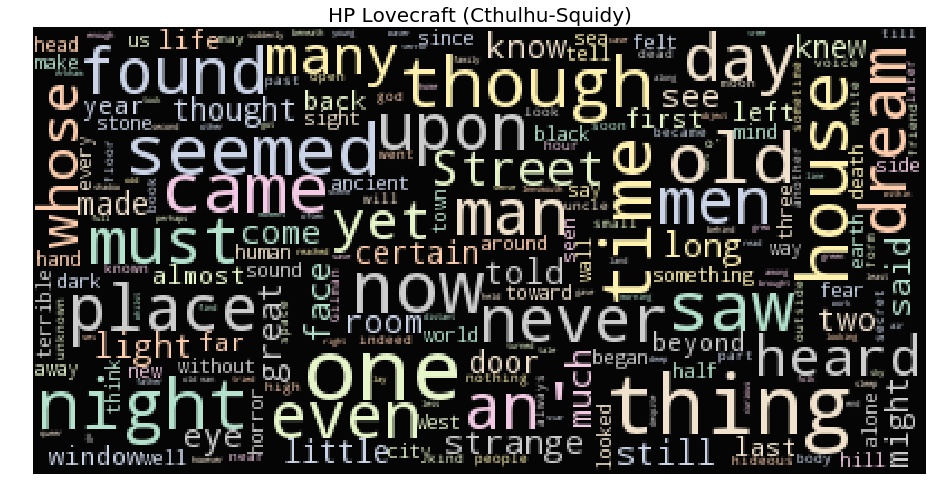

In [30]:
plt.figure(figsize=(16,13))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(hpl))
plt.title("HP Lovecraft (Cthulhu-Squidy)", fontsize=20)
# plt.imshow(wc.recolor( colormap= 'Pastel1_r' , random_state=17), alpha=0.98)
plt.imshow(wc.recolor( colormap= 'Pastel2' , random_state=17), alpha=0.98)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

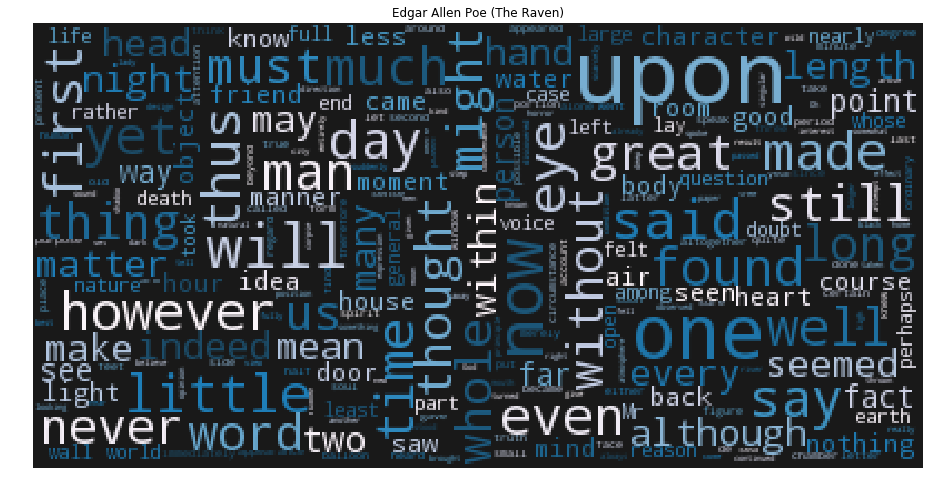

In [31]:
plt.figure(figsize=(20,18))
# The wordcloud of the raven for Edgar Allen Poe
plt.subplot(211)
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(eap))
plt.title("Edgar Allen Poe (The Raven)")
plt.imshow(wc.recolor( colormap= 'PuBu' , random_state=17), alpha=0.9)
plt.axis('off')

(-0.5, 399.5, 199.5, -0.5)

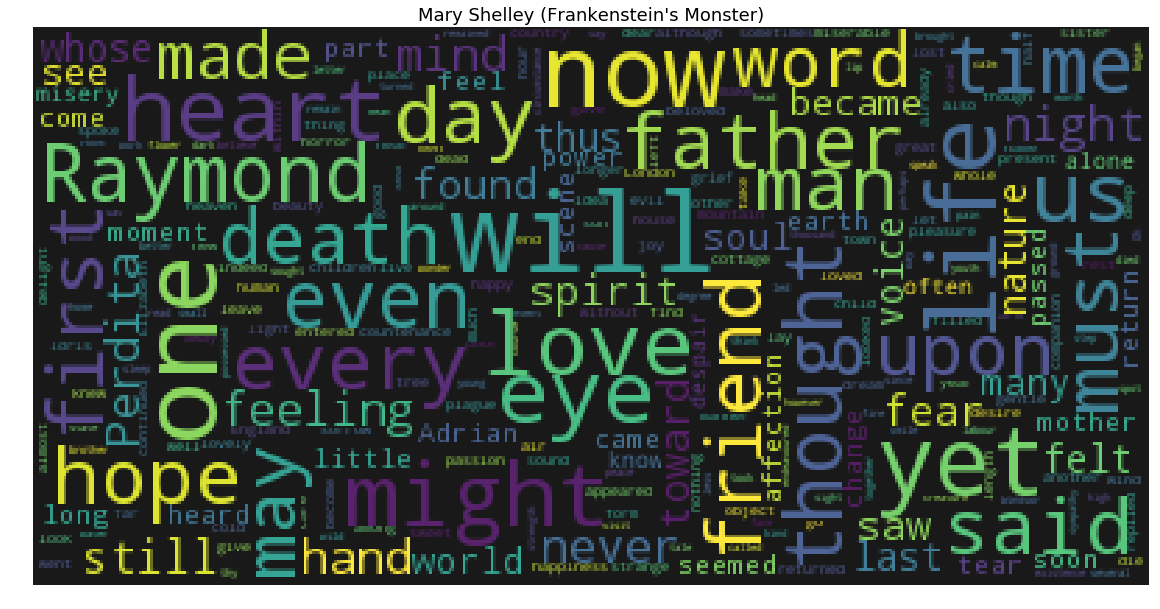

In [32]:
plt.figure(figsize=(20,18))
wc = WordCloud(background_color="black", max_words=10000, 
               stopwords=STOPWORDS, max_font_size= 40)
wc.generate(" ".join(mws))
plt.title("Mary Shelley (Frankenstein's Monster)", fontsize= 18)
plt.imshow(wc.recolor( colormap= 'viridis' , random_state=17), alpha=0.9)
plt.axis('off')

# 自然语言处理

In [33]:
# tokenization(分词)
# stopword removal(高频词去除)
first_text = train.text.values[0]
first_text_list = nltk.word_tokenize(first_text)
stopwords = nltk.corpus.stopwords.words('english')
first_text_list_cleaned = [word for word in first_text_list if word.lower() not in stopwords]
first_text_list

['This',
 'process',
 ',',
 'however',
 ',',
 'afforded',
 'me',
 'no',
 'means',
 'of',
 'ascertaining',
 'the',
 'dimensions',
 'of',
 'my',
 'dungeon',
 ';',
 'as',
 'I',
 'might',
 'make',
 'its',
 'circuit',
 ',',
 'and',
 'return',
 'to',
 'the',
 'point',
 'whence',
 'I',
 'set',
 'out',
 ',',
 'without',
 'being',
 'aware',
 'of',
 'the',
 'fact',
 ';',
 'so',
 'perfectly',
 'uniform',
 'seemed',
 'the',
 'wall',
 '.']

In [34]:
# stemming and lemmatization(词干提取)
stemmer = nltk.stem.PorterStemmer()
from nltk.stem import WordNetLemmatizer
lemm = WordNetLemmatizer()

In [35]:
# vectorizer(向量化，为了机器可读)

In [59]:
# bag_words
all_words = set(train['text'].str.split(expand=True).unstack())

def wordandindex(vocab):
    return {word: i + 3 for i, word in enumerate(vocab)}, {i + 3: word for i, word in enumerate(vocab)}

word2index, index2word = wordandindex(all_words)

In [84]:
# 最长句子长度设置为 input_size
max = 0
for i, x in enumerate(X):
    # print(len(x))
    if len(x) > max:
        max = len(x)
        
print(max)
# train.iloc[9215].values

# 参数
input_size = 861
num_classes = 3
epochs = 1

861


In [85]:
label_encoder = LabelEncoder()
# 数据集准备
X = np.array(train.text.apply(lambda sen: [word2index[word] for word in sen.split(' ')]))
y = np.array(label_encoder.fit_transform(train.author))
assert len(X) == len(y)
print(len(all_words))
print(len(train))
print("test length: {}".format(len(test)))
# 句子填充
X_pad = np.zeros((19579, 861))

for i in range(X_pad.shape[0]):
    for j in range(len(X[i])):
        X_pad[i, j] = X[i][j]

xtrain, xvalid, ytrain, yvalid = train_test_split(
    X_pad, y, 
    stratify=y, 
    random_state=42, 
    test_size=0.1, 
    shuffle=True
)
print("train length: {}".format(len(xtrain)))
#print(xtrain.type)
print("valid length: {}".format(len(xvalid)))
#print(xvalid.type)

47557
19579
test length: 8392
train length: 17621
valid length: 1958


In [86]:
# 逻辑回归
class LR(nn.Module):
    def __init__(self, input_size, num_classes):
        super(LR, self).__init__()
        self.linear_1 = nn.Linear(input_size, 256)
        self.linear_2 = nn.Linear(256, 128)
        self.linear_3 = nn.Linear(128, 64)
        self.linear_4 = nn.Linear(64, num_classes)
    
    def forward(self, x):
        L1_out = F.elu(self.linear_1(x))
        L2_out = F.elu(self.linear_2(L1_out))
        L3_out = F.elu(self.linear_3(L2_out))
        final_out = self.linear_4(L3_out)
        
        return final_out
    
model = LR(input_size, num_classes)

In [ ]:
# 训练模型
for epoch in range(epochs):
    